第4回のコピペ

### ランドマークの準備

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

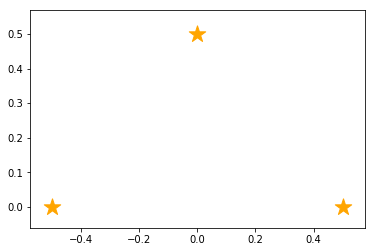

In [2]:
def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
draw_landmarks(actual_landmarks)

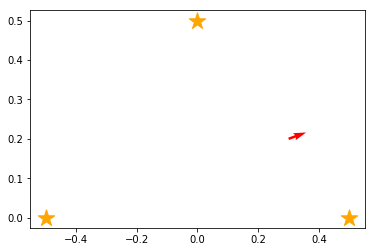

In [3]:

actual_x = np.array([0.3,0.2,math.pi*20.0/180])   #ロボットの実際の姿勢

def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
draw_robot(actual_x)
draw_landmarks(actual_landmarks)

In [4]:
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly) # 実際の位置も一緒に返す

In [5]:
measurements = [ relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)

def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)

[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5)]


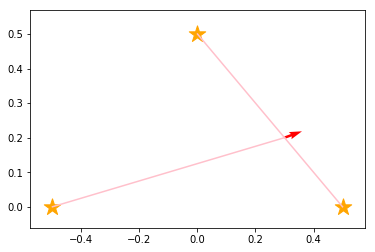

In [6]:
draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x,measurements)

### ランドマーク観測に誤差の情報を入れる

* 正規分布に従うノイズを混入させる
  * 観測した方向に距離の10%のノイズ
  * 観測した方向と垂直な方向に$距離\times\sin(5[\text{deg}])$のノイズ

In [7]:
def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    # 方向の制限（cosの値が正）
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)
    
    # cov1（姿勢1でのロボット座標系で定義）を回転して世界座標系の向きにするための回転行列
    c = math.cos(pose[2] + measured_direction)
    s = math.sin(pose[2] + measured_direction)
    rot = np.array([[  c,s],
                    [-s,c]])
    
    ## 誤差のガウス分布を作る
    err_robot = np.array([[(measured_distance*0.1)**2,0.0],
                        [0.0,(measured_distance*math.sin(5.0/180.0*math.pi))**2]])
    err_world = (rot).dot(err_robot).dot((rot).T)
    
    return (measured_distance, measured_direction,err_world,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

def ellipse(x,y,cov):
    eigen = np.linalg.eig(cov)
    v1 = eigen[0][0] * eigen[1][0]
    v2 = eigen[0][1] * eigen[1][1]
    v1_direction = math.atan2(v1[1],v1[0])
    
    elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
    elli.set_alpha(0.2)
    return elli 

# draw_observationを上書き
def draw_observation(pose,  measurement,sp):
    x,y,theta = pose
    distance, direction,cov,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    sp.add_artist(ellipse(lx,ly,cov))
    
def draw_observations(pose, measurements,sp):
    for m in measurements:
        draw_observation(pose, m, sp)

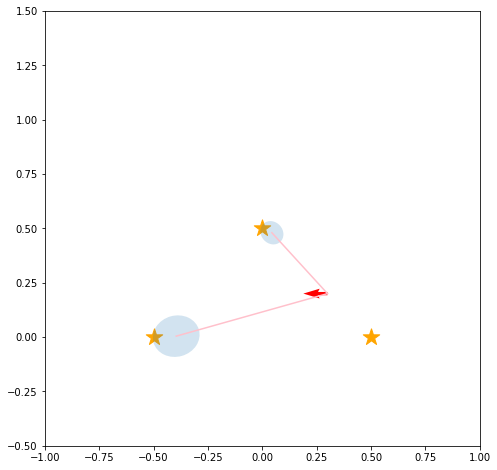

In [8]:
actual_x = np.array([0.3,0.2,math.pi*180.0/180])   #姿勢は変えること
measurements = observations(actual_x, actual_landmarks)

def draw(i):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)

    draw_landmarks(actual_landmarks)
    draw_robot(actual_x)
    draw_observations(actual_x, measurements,sp)
    
draw(1)

## ロボットの歩行モデル

In [9]:
def motion(pos, fw, rot):
    actual_fw = random.gauss(fw,fw/10)    #標準偏差にしてfwの10%だけ移動距離に雑音を入れる
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg] 
        
    px, py, pt = pos
        
    #前進させる
    x = px + actual_fw * math.cos(pt + dir_error)
    y = py + actual_fw * math.sin(pt + dir_error)
        
    #回転。回転角にもrotの10%だけ雑音を入れる
    t = pt + dir_error + random.gauss(rot,rot/10)
        
    return np.array([x,y,t])

## FastSLAMの実装

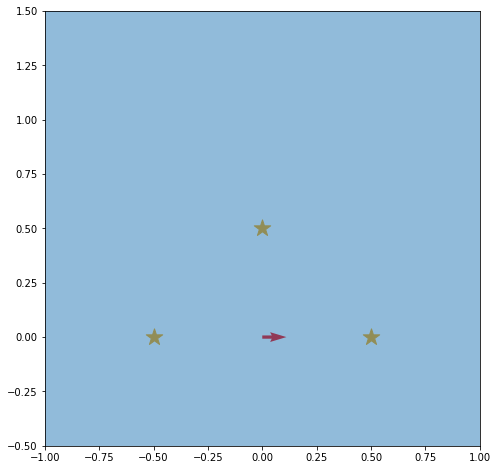

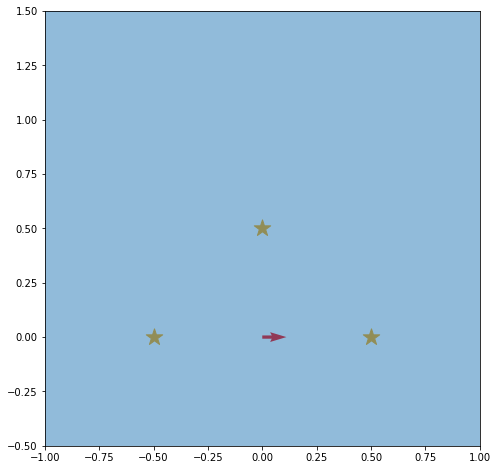

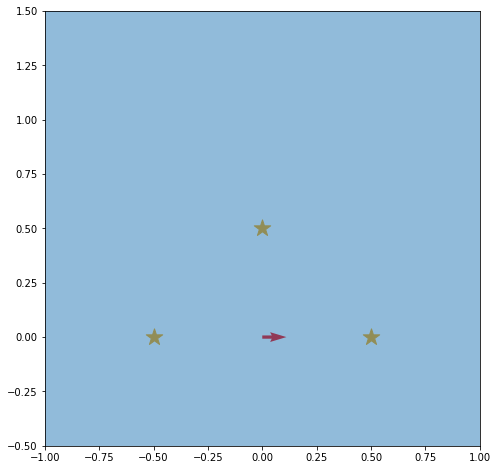

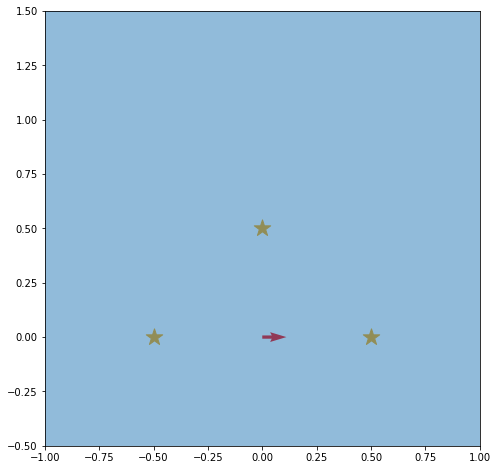

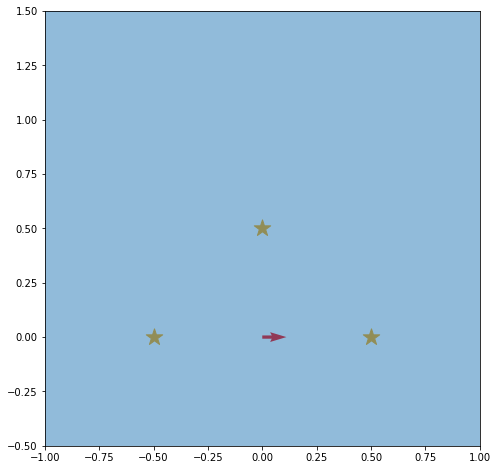

In [10]:
actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢

class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([0.0,0.0])
        self.cov = np.array([[1000000000.0**2,0.0],
                            [0.0,1000000000.0**2]])

class Particle():
    def __init__(self,pose):
        self.pose = pose
        self.map = [LandmarkEstimation(),LandmarkEstimation(),LandmarkEstimation()]
        
    def motion_update(self, fw, rot):
        self.pose = motion(self.pose, fw, rot)
        
    def draw(self,i):
        fig = plt.figure(i,figsize=(8, 8))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        draw_landmarks(actual_landmarks)
        draw_robot(self.pose)
        
        es = [ellipse(e.pos[0],e.pos[1],e.cov) for e in self.map]
        for e in es:
            sp.add_artist(e)
        
class FastSLAM():
    def __init__(self,pose):
        self.particles = [Particle(pose) for i in range(100)]
        
    def draw(self):
        for (i,p) in enumerate(self.particles):
            p.draw(i)
            if i > 3: return
            
    def motion_update(self, fw, rot):
        for p in self.particles:
            p.motion_update(fw,rot)
        
slam = FastSLAM(actual_x)
slam.draw()

In [11]:
actual_x = motion(actual_x, 0.2, math.pi / 180.0 * 20)

In [ ]:
slam.m